In [166]:
import pandas as pd
import glob

In [180]:
import re

def get_shap_stats(df_avg, df, loop_order):
    rules = {
        # centrality & spectral
        r"centrality": "Centrality",
        r"lap_eig": "Eigenvalues",

        # induced motifs (be specific first!)
        r"induced_connected_per_4set": "motif_4_induced",
        r"induced_connected_per_5set": "motif_5_induced",
        r"induced5_g_.*_5": "motif_5_induced",
        r"induced_g_.*_4": "motif_4_induced",

        # general motifs by size (non-induced)
        r"(triangle|triangles|wedge)": "motif_3",
        r"(4_cycles|4_cliques)": "motif_4",
        r"(5_cycles|5_cliques)": "motif_5",
    }

    def assign_group(feature: str) -> str:
        f = feature.lower()
        for pattern, label in rules.items():
            if re.search(pattern, f):
                return label
        return "other"

    df_avg["group"] = df_avg["feature"].apply(assign_group)

    shap_direction = pd.DataFrame((df > 0).mean(0)).reset_index()
    shap_direction.columns = ['feature','Direction Ratio']
    df_avg = df_avg.merge(shap_direction, on = ['feature'])


    efect_bias_ratio = pd.DataFrame(df.mean(axis = 0).abs()/ df.abs().mean(axis = 0)).reset_index().fillna(0)
    efect_bias_ratio.columns = ['feature','Bias Ratio']
    df_avg = df_avg.merge(efect_bias_ratio, on = ['feature'])



    # since its only one thing - I'll remove for the presentation
    df_avg = df_avg[df_avg['group'] != 'other']


    mss = (
        df_avg.assign(abs_val=df_avg["mean_signed_shap"].abs())
            .loc[
                lambda d: d.groupby("group")["abs_val"].idxmax()
            ][["group", "mean_signed_shap"]]
    ).set_index('group')

    dr = df_avg[['group','Direction Ratio']].groupby('group').max()
    br = df_avg[['group','Bias Ratio']].groupby('group').max()

    mss.columns = [loop_order]
    dr.columns = [loop_order]
    br.columns = [loop_order]

    return mss, dr, br


In [181]:
all_mss = []
all_dr = []
all_br = []
for loop_order in [6,7,8,9,10,11]:

    df_avg = pd.read_csv(f"/Users/rezadoobary/Documents/MLcorr_docs/loop{loop_order}/motifs_eig_centrality_/loop{loop_order}_motifs_eig_centrality_shap_full.csv")
    df = pd.read_csv(f"/Users/rezadoobary/Documents/MLcorr_docs/loop{loop_order}/motifs_eig_centrality_/loop{loop_order}_motifs_eig_centrality_shap_sample.csv")

    mss, dr, br = get_shap_stats(df_avg, df, loop_order)
    all_mss.append(mss)
    all_dr.append(dr)
    all_br.append(br)

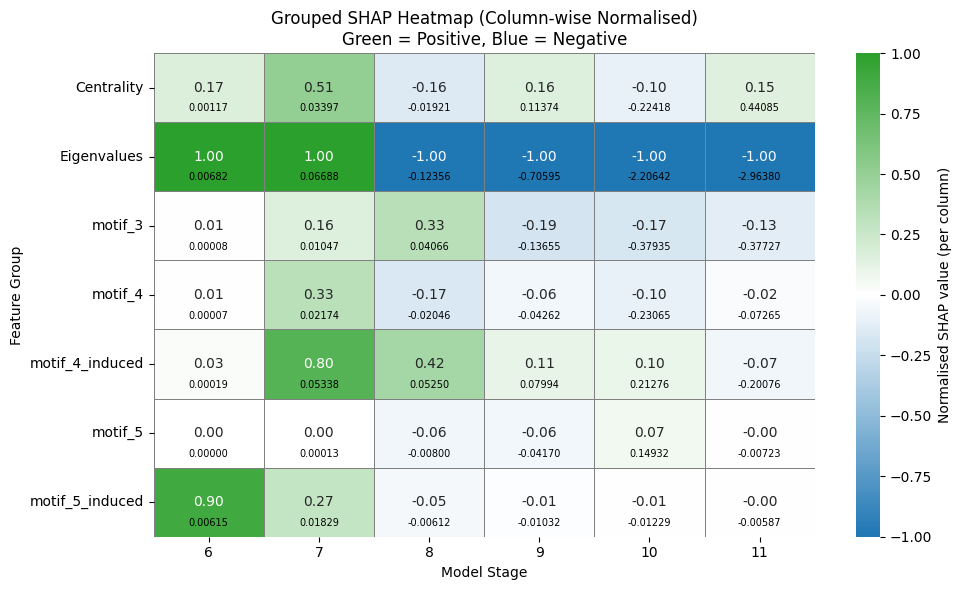

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Your data
data = pd.concat(all_mss, axis=1)

# Normalize each column by max absolute value in that column
norm_data = data.div(data.abs().max())

# Custom blue → white → green colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white_green",
    ["#1f77b4", "white", "#2ca02c"]   # blue → white → green
)

# Since data is already normalized to [-1, 1], center at zero
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

plt.figure(figsize=(10, 6))

ax = sns.heatmap(
    norm_data,
    cmap=cmap,
    norm=norm,
    linewidths=.4,
    linecolor='gray',
    annot=True,                 # show NORMALISED values
    fmt=".2f",
    cbar_kws={"label": "Normalised SHAP value (per column)"}
)

# Add RAW values underneath, smaller font
n_rows, n_cols = data.shape
for i in range(n_rows):
    for j in range(n_cols):
        raw_val = data.iloc[i, j]

        ax.text(
            j + 0.5,               # x-position (cell center)
            i + 0.8,               # y-position (a bit lower than center)
            f"{raw_val:.5f}",      # raw value text
            ha="center",
            va="center",
            fontsize=7,
            color="black"
        )

plt.title("Grouped SHAP Heatmap (Column-wise Normalised)\nGreen = Positive, Blue = Negative")
plt.xlabel("Model Stage")
plt.ylabel("Feature Group")
plt.tight_layout()
plt.show()


#Positive → feature increases prediction on average

#Negative → feature decreases prediction on average

#This gives direction but not consistency (a feature with highly mixed positive & negative effects may average close to zero).

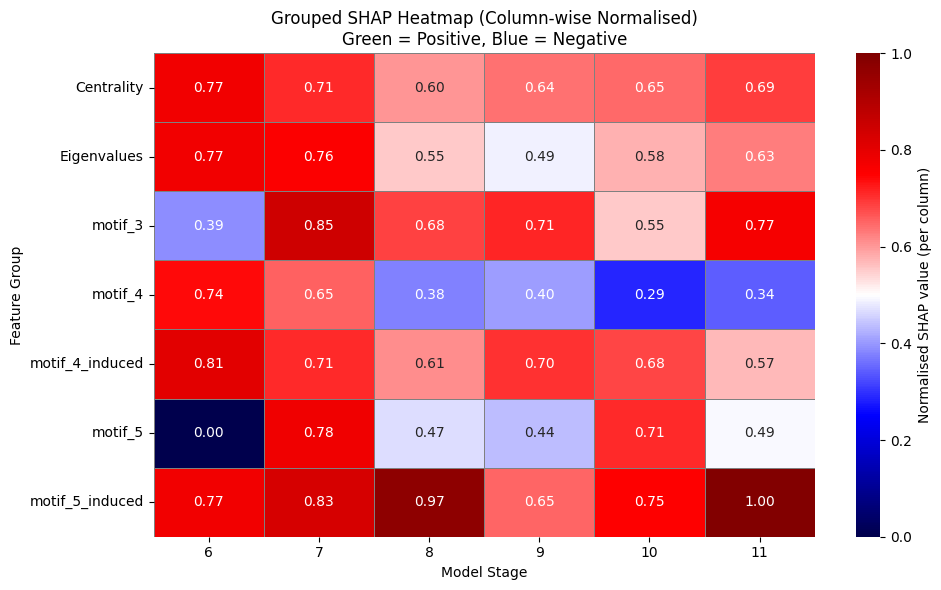

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Your data
data = pd.concat(all_dr, axis=1)

# Normalize each column by max absolute value in that column
norm_data = data#data.div(data.abs().max())

# Custom blue → white → green colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white_green",
    ["#1f77b4", "white", "#2ca02c"]   # blue → white → green
)
cmap = sns.color_palette("seismic", as_cmap=True)

# Since data is already normalized to [-1, 1], center at zero
norm = mcolors.TwoSlopeNorm(vcenter=0.5, vmin=0, vmax=1)

plt.figure(figsize=(10, 6))

ax = sns.heatmap(
    norm_data,
    cmap=cmap,
    norm=norm,
    linewidths=.4,
    linecolor='gray',
    annot=True,                 # show NORMALISED values
    fmt=".2f",
    cbar_kws={"label": "Normalised SHAP value (per column)"}
)



plt.title("Grouped SHAP Heatmap (Column-wise Normalised)\nGreen = Positive, Blue = Negative")
plt.xlabel("Model Stage")
plt.ylabel("Feature Group")
plt.tight_layout()
plt.show()


#| Value | Meaning                                       |
#| ----- | --------------------------------------------- |
#| ~1.0  | Feature almost always increases prediction    |
#| ~0.5  | Feature has mixed effects (context dependent) |
#| ~0.0  | Feature almost always decreases prediction    |



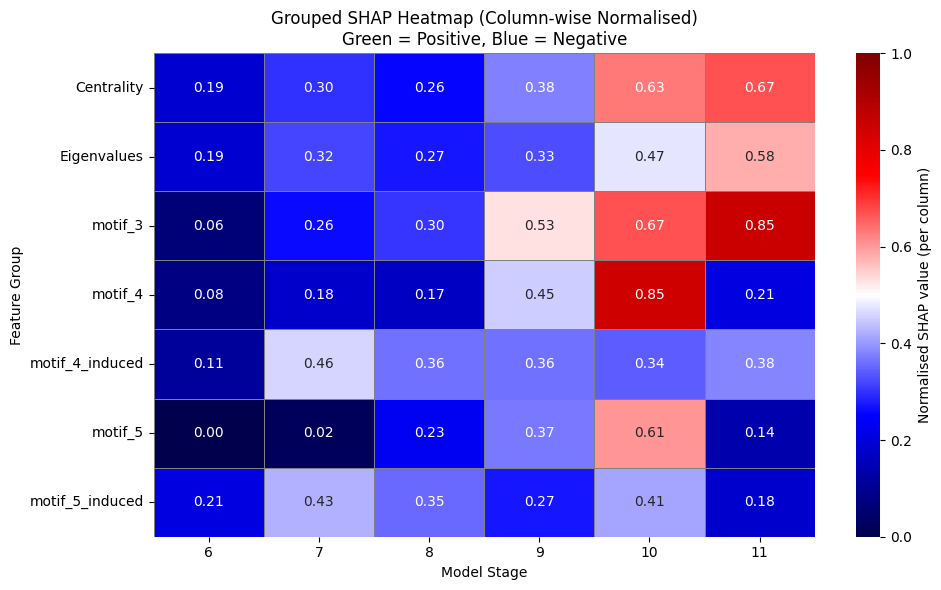

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Your data
data = pd.concat(all_br, axis=1)

# Normalize each column by max absolute value in that column
norm_data = data#data.div(data.abs().max())

# Custom blue → white → green colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white_green",
    ["#1f77b4", "white", "#2ca02c"]   # blue → white → green
)
cmap = sns.color_palette("seismic", as_cmap=True)

# Since data is already normalized to [-1, 1], center at zero
norm = mcolors.TwoSlopeNorm(vcenter=0.5, vmin=0, vmax=1)

plt.figure(figsize=(10, 6))

ax = sns.heatmap(
    norm_data,
    cmap=cmap,
    norm=norm,
    linewidths=.4,
    linecolor='gray',
    annot=True,                 # show NORMALISED values
    fmt=".2f",
    cbar_kws={"label": "Normalised SHAP value (per column)"}
)



plt.title("Grouped SHAP Heatmap (Column-wise Normalised)\nGreen = Positive, Blue = Negative")
plt.xlabel("Model Stage")
plt.ylabel("Feature Group")
plt.tight_layout()
plt.show()



#| Value | Interpretation                                                     |
#| ----- | ------------------------------------------------------------------ |
#| 0     | Perfectly balanced up/down effect (context-driven feature)         |
#| 1     | Direction is strong and consistent (feature always pushes one way) |


In [107]:
# we looked at features groups - can also look at specific features to yield something more?

In [ ]:
import re

def get_shap_stats(df_avg, df, loop_order):
    rules = {
        # centrality & spectral
        r"centrality": "Centrality",
        r"lap_eig": "Eigenvalues",

        # induced motifs (be specific first!)
        r"induced_connected_per_4set": "motif_4_induced",
        r"induced_connected_per_5set": "motif_5_induced",
        r"induced5_g_.*_5": "motif_5_induced",
        r"induced_g_.*_4": "motif_4_induced",

        # general motifs by size (non-induced)
        r"(triangle|triangles|wedge)": "motif_3",
        r"(4_cycles|4_cliques)": "motif_4",
        r"(5_cycles|5_cliques)": "motif_5",
    }

    def assign_group(feature: str) -> str:
        f = feature.lower()
        for pattern, label in rules.items():
            if re.search(pattern, f):
                return label
        return "other"

    df_avg["group"] = df_avg["feature"].apply(assign_group)

    shap_direction = pd.DataFrame((df > 0).mean(0)).reset_index()
    shap_direction.columns = ['feature','Direction Ratio']
    df_avg = df_avg.merge(shap_direction, on = ['feature'])


    efect_bias_ratio = pd.DataFrame(df.mean(axis = 0).abs()/ df.abs().mean(axis = 0)).reset_index().fillna(0)
    efect_bias_ratio.columns = ['feature','Bias Ratio']
    df_avg = df_avg.merge(efect_bias_ratio, on = ['feature'])



    # since its only one thing - I'll remove for the presentation
    df_avg = df_avg[df_avg['group'] != 'other']


    mss = df_avg[['group','mean_signed_shap']].groupby('group').mean()
    dr = df_avg[['group','Direction Ratio']].groupby('group').mean()
    br = df_avg[['group','Bias Ratio']].groupby('group').mean()

    mss.columns = [loop_order]
    dr.columns = [loop_order]
    br.columns = [loop_order]

    return mss, dr, br


In [150]:
import re

def get_all_shap_stats(df_avg, df, loop_order):
    
    shap_direction = pd.DataFrame((df > 0).mean(0)).reset_index()
    shap_direction.columns = ['feature','Direction Ratio']
    df_avg = df_avg.merge(shap_direction, on = ['feature'])


    efect_bias_ratio = pd.DataFrame(df.mean(axis = 0).abs()/ df.abs().mean(axis = 0)).reset_index().fillna(0)
    efect_bias_ratio.columns = ['feature','Bias Ratio']
    df_avg = df_avg.merge(efect_bias_ratio, on = ['feature'])



    #mss = df_avg[['group','mean_signed_shap']].groupby('group').mean()
    #dr = df_avg[['group','Direction Ratio']].groupby('group').mean()
    #br = df_avg[['group','Bias Ratio']].groupby('group').mean()

    #mss.columns = [loop_order]
    #dr.columns = [loop_order]
    #br.columns = [loop_order]
    mss = df_avg[['feature', 'mean_signed_shap']].set_index('feature')
    dr = df_avg[['feature', 'Direction Ratio']].set_index('feature')
    br = df_avg[['feature', 'Bias Ratio']].set_index('feature')


    mss.columns = [loop_order]
    dr.columns = [loop_order]
    br.columns = [loop_order]



    return mss, dr, br


all_mss = []
all_dr = []
all_br = []
for loop_order in [6,7,8,9,10,11]:

    df_avg = pd.read_csv(f"/Users/rezadoobary/Documents/MLcorr_docs/loop{loop_order}/motifs_eig_centrality_/loop{loop_order}_motifs_eig_centrality_shap_full.csv")
    df = pd.read_csv(f"/Users/rezadoobary/Documents/MLcorr_docs/loop{loop_order}/motifs_eig_centrality_/loop{loop_order}_motifs_eig_centrality_shap_sample.csv")

    mss, dr, br = get_all_shap_stats(df_avg, df, loop_order)

    mss = mss.abs().sort_values(loop_order)[::-1][:40]
    dr = dr.abs().sort_values(loop_order)[::-1][:40]
    br = br.abs().sort_values(loop_order)[::-1][:40]

    all_mss.append(mss)
    all_dr.append(dr)
    all_br.append(br)


In [164]:
df_new = pd.concat([all_mss[-1], all_dr[-1], all_br[-1]], axis = 1).dropna()
df_new.columns = ['mss', 'dr', 'br']

In [165]:
df_new.sort_values('br')[::-1][:10]

,mss,dr,br
feature,,,
Motif_wedges,0.337301,0.7666,0.854814
Centrality_betweenness_std,0.440846,0.6891,0.602001
Motif_wedges_per_max,0.017396,0.6243,0.513098
Motif_triangle_edge_incidence_mean,0.055679,0.6374,0.399877
Spectral_lap_eig_2,0.258815,0.6279,0.302661
Centrality_betweenness_max,0.078544,0.5875,0.281220
Motif_5_cycles,0.007226,0.4644,0.136572
Motif_induced_connected_per_4set,0.200764,0.5695,0.136455


In [163]:
df_new.sort_values('br')[::-1][:10]

,mss,dr,br
feature,,,
Motif_induced5_g_15_5,0.006145,0.774194,0.207975
Centrality_eigenvector_mean,0.000284,0.548387,0.186107
Spectral_lap_eig_1,0.006825,0.774194,0.185736
Motif_induced5_g_5_5,0.001008,0.774194,0.164804
Spectral_lap_eig_3,0.000176,0.741935,0.161260
Motif_induced5_g_15_5_per_Cn5,0.000985,0.774194,0.156078
Motif_induced_connected_per_5set,0.000271,0.774194,0.155959
Centrality_eigenvector_skew,0.000350,0.774194,0.129274
Centrality_betweenness_skew,0.000751,0.741935,0.120132


In [157]:
df_new.columns

Index([6, 6, 6], dtype='int64')

In [147]:
pd.concat([all_mss[0], all_dr[0], all_br[0]], axis = 1)

,6,6,6
feature,,,
Spectral_lap_eig_1,0.006825,0.774194,0.185736
Motif_induced5_g_15_5,0.006145,0.774194,0.207975
Centrality_closeness_mean,0.001167,NaN,NaN
Spectral_lap_eig_6,0.001164,NaN,NaN
Motif_induced5_g_5_5,0.001008,0.774194,0.164804
Motif_induced5_g_15_5_per_Cn5,0.000985,0.774194,0.156078
Centrality_betweenness_skew,0.000751,NaN,0.120132
Centrality_eigenvector_max,0.000392,NaN,NaN
Centrality_eigenvector_skew,0.000350,0.774194,0.129274


In [120]:
res = pd.concat(all_br, axis =1)

In [125]:
res[11].sort_values()[::-1][:10]

feature
Motif_wedges                    0.854814
Centrality_closeness_max        0.669602
Centrality_betweenness_std      0.602001
Spectral_lap_eig_1              0.578664
Centrality_eigenvector_max      0.574516
Motif_wedges_per_max            0.513098
Spectral_lap_eig_4              0.500632
Motif_triangles_per_Cn3         0.469313
Centrality_betweenness_mean     0.443907
Motif_triangle_edge_frac_ge2    0.439179
Name: 11, dtype: float64

In [126]:
res[6].sort_values()[::-1][:10]

feature
Motif_induced5_g_15_5               0.207975
Centrality_eigenvector_mean         0.186107
Spectral_lap_eig_1                  0.185736
Motif_induced5_g_5_5                0.164804
Spectral_lap_eig_3                  0.161260
Motif_induced5_g_15_5_per_Cn5       0.156078
Motif_induced_connected_per_5set    0.155959
Centrality_eigenvector_skew         0.129274
Centrality_betweenness_skew         0.120132
Motif_induced_g_1_4                 0.110876
Name: 6, dtype: float64

In [ ]:
pd.read_csv("/Users/rezaaaadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/results/reports/results_20251006_224933.csv")

,experiment_type,train_loops,test_loops,n_train,n_test,train_auc,test_auc,train_auc_std,test_auc_std,best_params
0,intra-loop,6,6,36,36,0.980030,0.933333,0.008235,0.058689,"{""subsample"": 0.85, ""reg_lambda"": 2.0, ""reg_al..."
1,intra-loop,7,7,220,220,0.913159,0.744117,0.042594,0.053652,"{""subsample"": 1.0, ""reg_lambda"": 1.0, ""reg_alp..."
2,intra-loop,8,8,2709,2709,0.864150,0.815280,0.014743,0.020096,"{""subsample"": 0.7, ""reg_lambda"": 0.5, ""reg_alp..."
3,intra-loop,9,9,43017,43017,0.822136,0.798852,0.003920,0.005249,"{""subsample"": 0.85, ""reg_lambda"": 0.5, ""reg_al..."
4,mixed,6,7,36,220,0.976923,0.751291,NaN,NaN,"{""subsample"": 0.85, ""reg_lambda"": 2.0, ""reg_al..."
5,mixed,7,8,220,2709,0.939844,0.775218,NaN,NaN,"{""subsample"": 1.0, ""reg_lambda"": 1.0, ""reg_alp..."
6,mixed,8,9,2709,43017,0.881142,0.761015,NaN,NaN,"{""subsample"": 0.85, ""reg_lambda"": 2.0, ""reg_al..."
7,mixed,6,8,36,2709,0.976923,0.682171,NaN,NaN,"{""subsample"": 0.85, ""reg_lambda"": 2.0, ""reg_al..."
8,mixed,6,9,36,43017,0.976923,0.660049,NaN,NaN,"{""subsample"": 0.85, ""reg_lambda"": 2.0, ""reg_al..."
9,mixed,7,9,220,43017,0.939844,0.727338,NaN,NaN,"{""subsample"": 1.0, ""reg_lambda"": 1.0, ""reg_alp..."
